In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Configuration
DATA_DIR = r"C:\Users\Shree\OneDrive\Desktop\anoamly\UCSDped2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
EPOCHS = 5  # Train for at least 10-15 epochs
SEQ_LEN = 10  # Frames per clip
IMG_SIZE = (128, 128)
LR = 1e-3



c:\Users\Shree\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#dataset class
class UCSD_Dataset(Dataset):
    def __init__(self, root_dir, mode='train', seq_len=10, transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.seq_len = seq_len
        self.transform = transform
        self.clips = []
        
        folder = 'Train' if mode == 'train' else 'Test'
        search_path = os.path.join(root_dir, folder)
        
        for seq_folder in sorted(os.listdir(search_path)):
            seq_path = os.path.join(search_path, seq_folder)
            if os.path.isdir(seq_path):
                images = sorted([os.path.join(seq_path, f) for f in os.listdir(seq_path) if f.endswith('.tif')])
                
                # Create sliding window clips
                for i in range(len(images) - seq_len + 1):
                    self.clips.append(images[i : i + seq_len])
                    
    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        paths = self.clips[idx]
        frames = []
        for p in paths:
            img = Image.open(p).convert('L')
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        return torch.stack(frames), torch.stack(frames) # Input == Target

In [5]:
#cnn autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 16
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        b, s, c, h, w = x.shape
        x = x.view(b * s, c, h, w)
        out = self.decoder(self.encoder(x))
        return out.view(b, s, c, h, w)

model = ConvAutoencoder().to(DEVICE)
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


In [6]:
#data loading
transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])

train_ds = UCSD_Dataset(DATA_DIR, 'train', SEQ_LEN, transform)
test_ds = UCSD_Dataset(DATA_DIR, 'test', SEQ_LEN, transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

In [11]:
#traing looping
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs, _ = data
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.6f}")
print("Training Complete!")

Starting Training...


Epoch 1: 100%|██████████| 602/602 [10:02<00:00,  1.00s/it]


Epoch 1 Loss: 0.003318


Epoch 2: 100%|██████████| 602/602 [09:49<00:00,  1.02it/s]


Epoch 2 Loss: 0.000785


Epoch 3: 100%|██████████| 602/602 [08:46<00:00,  1.14it/s]


Epoch 3 Loss: 0.000616


Epoch 4: 100%|██████████| 602/602 [08:22<00:00,  1.20it/s]


Epoch 4 Loss: 0.000535


Epoch 5: 100%|██████████| 602/602 [09:32<00:00,  1.05it/s]  

Epoch 5 Loss: 0.000486
Training Complete!


In [7]:
# Step 1: Define the Testing Function
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def test_anomaly_detection(video_path, model):
    print(f"Testing video: {video_path}")
    
    # 1. Setup Model for Evaluation
    model.eval()
    
    # 2. Setup Video Capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # 3. Setup Preprocessing (MUST match training)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),  # Same as IMG_SIZE in training
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    SEQ_LEN = 10  # Must match training sequence length
    frame_buffer = []
    errors = []
    frame_indices = []
    current_idx = 0

    print("Processing frames...")
    
    # 4. Process Video Loop
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess single frame
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            tensor_frame = transform(gray)
            
            frame_buffer.append(tensor_frame)

            # We need 10 frames to make a prediction
            if len(frame_buffer) == SEQ_LEN:
                # Stack: (Batch, Seq, Channel, H, W) -> (1, 10, 1, 128, 128)
                clip_tensor = torch.stack(frame_buffer).unsqueeze(0).to(DEVICE)
                
                # Predict
                output = model(clip_tensor)
                
                # Calculate Reconstruction Error (MSE)
                mse = torch.mean((clip_tensor - output) ** 2).item()
                
                errors.append(mse)
                frame_indices.append(current_idx)
                
                # Slide window: Remove oldest frame
                frame_buffer.pop(0)

            current_idx += 1

    cap.release()
    print("Processing complete. Generating graph...")

    # 5. Generate Analysis Graph
    # Calculate Threshold (Mean + 2 * Standard Deviation)
    errors = np.array(errors)
    mean_err = np.mean(errors)
    std_err = np.std(errors)
    threshold = mean_err + (2.0 * std_err) 

    # Plotting
    plt.figure(figsize=(15, 6))
    
    # Plot Error Line
    plt.plot(frame_indices, errors, label='Reconstruction Error', color='#3b82f6', linewidth=2)
    
    # Plot Threshold Line
    plt.axhline(y=threshold, color='#ef4444', linestyle='--', linewidth=2, label='Anomaly Threshold')
    
    # Highlight Anomalies (Red Shading)
    anomaly_indices = [i for i, e in zip(frame_indices, errors) if e > threshold]
    if anomaly_indices:
        plt.axvspan(min(anomaly_indices), max(anomaly_indices), color='red', alpha=0.2, label='Detected Event')

    plt.title(f"Test Results: {os.path.basename(video_path)}", fontsize=16)
    plt.xlabel("Frame Number", fontsize=12)
    plt.ylabel("Error Score (Lower is Normal)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Max Error: {np.max(errors):.5f}")
    print(f"Threshold: {threshold:.5f}")

Testing video: C:\Users\Shree\Downloads\WhatsApp Video 2026-01-13 at 11.10.34 AM.mp4
Processing frames...
Processing complete. Generating graph...


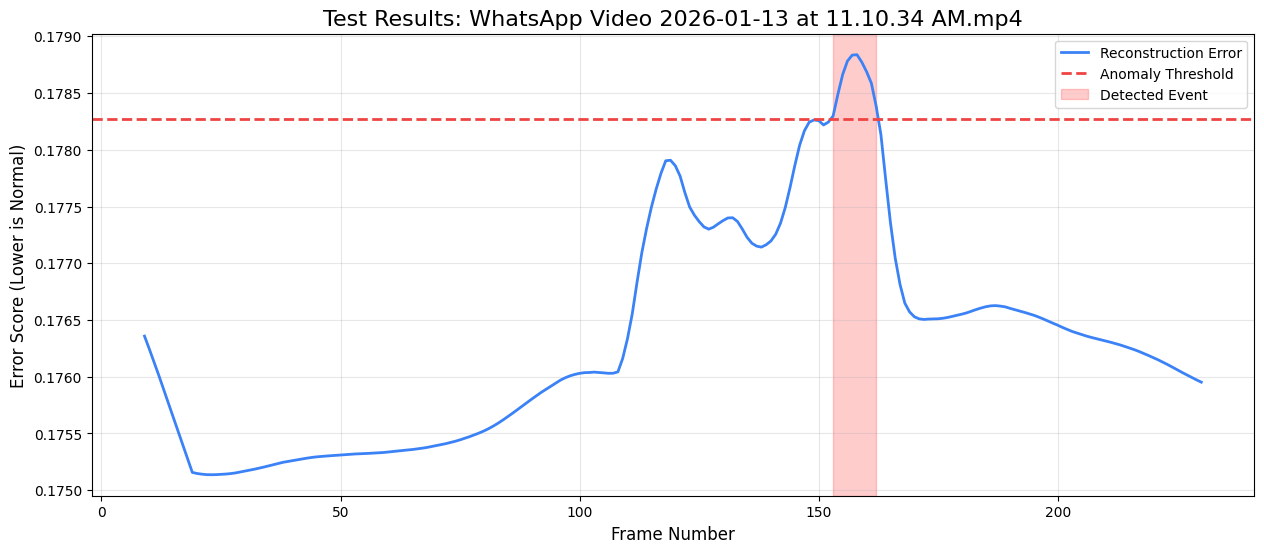

Max Error: 0.17884
Threshold: 0.17827


In [9]:
# Step 3: Run the Test on a Custom Video
import os

# CHANGE THIS PATH to your video file location
# e.g., r"C:\Users\Shree\Downloads\my_accident_video.mp4"
VIDEO_PATH = r"C:\Users\Shree\Downloads\WhatsApp Video 2026-01-13 at 11.10.34 AM.mp4" 

if os.path.exists(VIDEO_PATH):
    test_anomaly_detection(VIDEO_PATH, model)
else:
    print(f"File not found: {VIDEO_PATH}")

In [10]:
# Cell: Test and Show ONLY 3 Key Accident Frames
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def test_and_show_3_frames(video_path, model, threshold_sensitivity=2.5):
    print(f"Analyzing: {video_path}")
    
    model.eval()
    cap = cv2.VideoCapture(video_path)
    if not cap.get(cv2.CAP_PROP_FRAME_WIDTH):
        print("Error: Could not open video.")
        return

    # Preprocessing
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    SEQ_LEN = 10
    frame_buffer = []
    errors = []
    
    # Dictionary: { index: score }
    detected_indices = {} 
    current_idx = 0
    
    print("Detecting anomalies...")
    
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            tensor = transform(gray)
            
            frame_buffer.append(tensor)
            
            if len(frame_buffer) == SEQ_LEN:
                clip = torch.stack(frame_buffer).unsqueeze(0).to(DEVICE)
                output = model(clip)
                mse = torch.mean((clip - output) ** 2).item()
                errors.append(mse)
                
                # Calculate Threshold Dynamically
                mean_err = np.mean(errors)
                std_err = np.std(errors)
                threshold = mean_err + (threshold_sensitivity * std_err)
                
                if mse > threshold:
                    detected_indices[current_idx] = mse
                
                frame_buffer.pop(0)
            current_idx += 1
            
    cap.release()

    if not detected_indices:
        print("No accident detected.")
        return

    # --- SELECT EXACTLY 3 KEY FRAMES ---
    
    # Convert to list for easier sorting
    detected_list = [{"idx": k, "score": v} for k, v in detected_indices.items()]
    detected_list.sort(key=lambda x: x['idx']) # Sort by time

    # 1. THE START (First detected frame)
    frame_start = detected_list[0]

    # 2. THE PEAK (Highest score)
    frame_peak = max(detected_list, key=lambda x: x['score'])

    # 3. THE AFTERMATH (A frame later in the sequence)
    # Try to pick the 10th frame in the anomaly, or the last one if short
    frame_end = detected_list[min(10, len(detected_list)-1)]

    selected_frames = [frame_start, frame_peak, frame_end]

    # --- RELOAD VIDEO TO SAVE SPECIFIC FRAMES ---
    cap = cv2.VideoCapture(video_path)
    
    images_to_plot = []
    titles = []

    for item in selected_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, item['idx'])
        ret, frame = cap.read()
        if ret:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            images_to_plot.append(rgb)
            titles.append(f"Frame {item['idx']}\nScore: {item['score']:.2f}")
    
    cap.release()

    # --- PLOT THE 3 FRAMES ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    for i in range(3):
        axs[i].imshow(images_to_plot[i])
        axs[i].set_title(titles[i], fontsize=14, fontweight='bold')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("Displayed: Start, Peak, and End of the accident.")

Testing video: C:\Users\Shree\Downloads\WhatsApp Video 2026-01-13 at 11.10.34 AM.mp4
Processing frames...
Processing complete. Generating graph...


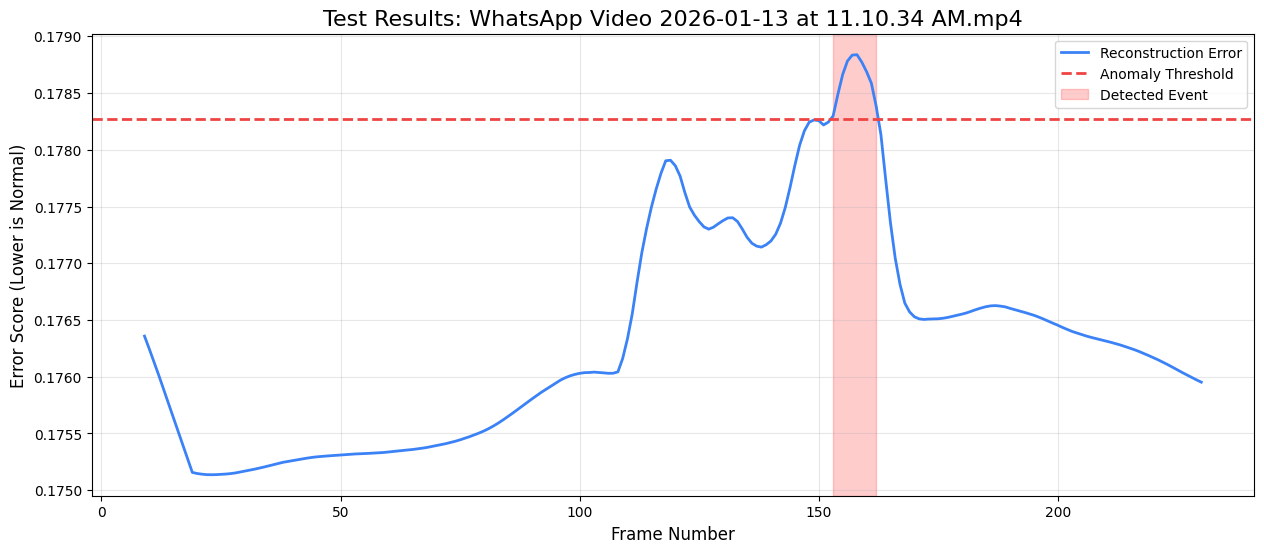

Max Error: 0.17884
Threshold: 0.17827
Analyzing: C:\Users\Shree\Downloads\WhatsApp Video 2026-01-13 at 11.10.34 AM.mp4
Detecting anomalies...


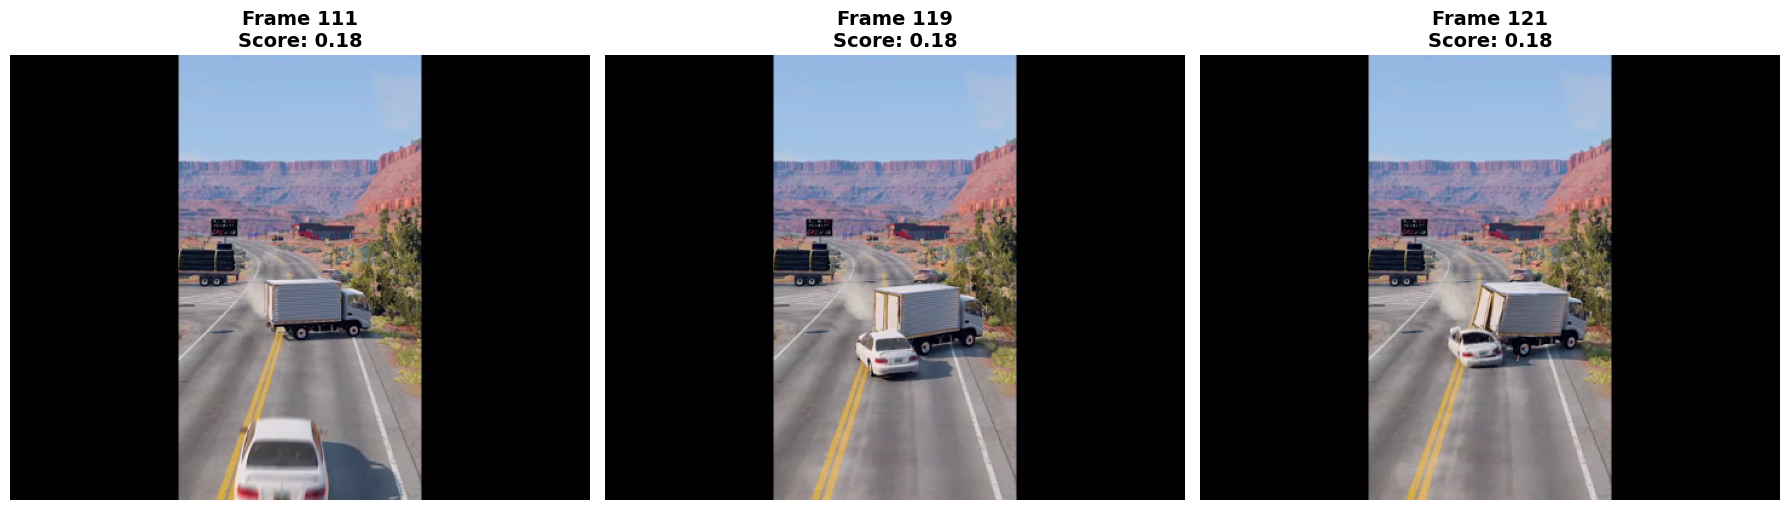

Displayed: Start, Peak, and End of the accident.


In [12]:

import os

# CHANGE THIS PATH to your video file location
# e.g., r"C:\Users\Shree\Downloads\my_accident_video.mp4"
VIDEO_PATH = r"C:\Users\Shree\Downloads\WhatsApp Video 2026-01-13 at 11.10.34 AM.mp4" 

if os.path.exists(VIDEO_PATH):
    test_anomaly_detection(VIDEO_PATH, model)
else:
    print(f"File not found: {VIDEO_PATH}")
    
# Run the function
test_and_show_3_frames(VIDEO_PATH, model)

In [13]:
# Recommended way: save only the state_dict
torch.save(model.state_dict(), 'model_weights.pth')